In [83]:
from datetime import datetime, timedelta
from mplsoccer import VerticalPitch, Pitch
from matplotlib import animation
import matplotlib.pyplot as plt
from pathlib import Path
import imageio.v2 as iio
from tqdm import tqdm
import pandas as pd
import matplotlib
import zipfile
import shutil
import time
import json
import enum
from pathlib import Path
from pathlib import Path
import zipfile
import numpy as np
# set pandas option to show columns of a dataframe
pd.set_option('display.max_columns', None)
import os
import sys
# Add the parent directory to sys.path to access the 'models' package
sys.path.append('..')

from models.setup_skillcorner import get_skillcorner_database, get_skillcorner_dataframes


In [84]:
def wyscout_json_to_df(file_name):
    # Create a directory to extract files to (same as zip file name without extension)
    extract_dir = file_name.split(".")[0]
    os.makedirs(extract_dir, exist_ok=True)  # Create the directory if it doesn't exist

    # Unzip the file
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    
    # Construct the full path to the json file
    json_name = os.path.join(extract_dir, os.path.basename(extract_dir) + ".json")

    # Read the json file
    with open(json_name, encoding='utf8') as f:
        js = json.load(f)
        df = pd.json_normalize(js['events'])
    return df

In [85]:
def filter_dataframe(team_name, df, halftime=None, pass_recived = True):
    #turnof nump warning 

    
    # Filter the dataframe to only include events from the specified team
    df = df[df['team.name'] == team_name]
    df["matchPeriod"] = df["matchPeriod"].apply(lambda x: 1 if x == "1H" else 2)
    if halftime != 1 or halftime != 2:
        halftime =1

    pass_mask = (df['type.primary'] == 'pass') & (df['matchPeriod'] == halftime ) & (df['pass.accurate'] == pass_recived)
    df = df.loc[pass_mask, ['location.x', 'location.y', 'pass.endLocation.x', 'pass.endLocation.y', "player.name", "pass.recipient.name"]]
    df["player.name"] = df["player.name"].apply(lambda x: x.split(" ")[-1] if x != None else None)
    df["pass.recipient.name"] = df["pass.recipient.name"].apply(lambda x: x.split(" ")[-1] if x != None else None)

    #dropna entries in the dataframe when they are in player name or pass recipent name
    df = df.dropna(subset=["player.name", "pass.recipient.name"])
    df = df.reset_index(drop=True)
    
    return df




In [86]:
def merge_wyscout_dfs(match_id_list, wyscout_path):
    for i, match_id in enumerate(match_id_list):
        df = wyscout_json_to_df(file_name=os.path.join(wyscout_path, f'{match_id}.zip'))
        if i == 0:
            df_all = df
        else:
            df_all = pd.concat([df_all, df], ignore_index=True)
    return df_all
    




In [87]:
def passes_visualization_halftime(england_match, wyscout_path, haltime, current_directory, team):
    plot_data = list()

    for index, match in england_match.iterrows():
        scatter_df = pd.DataFrame()
        match_df = wyscout_json_to_df(file_name=os.path.join(wyscout_path, f'{match["wyscout"]}.zip'))
        #get a copy of match_df called_wrongpasses_df
        wrongpasses_df = match_df.copy()

        wrongpasses_df = filter_dataframe(team, wrongpasses_df, haltime, pass_recived=False)
        match_df = filter_dataframe(team, match_df, haltime)

        for i, name in enumerate(match_df['player.name'].unique()):
            player_df = match_df[match_df['player.name'] == name]


            passx = match_df.loc[match_df["player.name"] == name]["location.x"].to_numpy()
            recx = match_df.loc[match_df["pass.recipient.name"] == name]["pass.endLocation.x"].to_numpy()
            passy = match_df.loc[match_df["player.name"] == name]["location.y"].to_numpy()
            recy = match_df.loc[match_df["pass.recipient.name"] == name]["pass.endLocation.y"].to_numpy()
            
            scatter_df.at[i, "player.name"] = name
            #make sure that x and y location for each circle representing the player is the average of passes and receptions
            scatter_df.at[i, "location.x"] = np.mean(np.concatenate([passx, recx]))
            scatter_df.at[i, "location.y"] = np.mean(np.concatenate([passy, recy]))
            #calculate number of passes
            scatter_df.at[i, "no"] = match_df.loc[match_df["player.name"] == name].count().iloc[0]
        
        scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 500)
        match_df["pair_key"] = match_df.apply(lambda x: "_".join(sorted([x["player.name"], x["pass.recipient.name"]])), axis=1)
        lines_df = match_df.groupby(["pair_key"])["location.x"].count().reset_index()
        lines_df.rename({'location.x':'pass_count'}, axis='columns', inplace=True)
        #setting a treshold. You can try to investigate how it changes when you change it.
        lines_df = lines_df[lines_df['pass_count']>2]


        plot_data.append({'lines_df': lines_df, 'scatter_df': scatter_df, 'match': match})




    for data in plot_data:

        pitch = Pitch(pitch_type='wyscout', goal_type='box', pitch_color='#53ac5c',
                            line_color='white', linewidth=3, corner_arcs=True)
        fig, ax = pitch.draw()
        lines = data['lines_df']
        scatter = data['scatter_df']
        match = data['match']

        ax.scatter(scatter['location.x'], scatter['location.y'], s=scatter['marker_size'], color='red', edgecolors='black', zorder=1)

        for i, row in lines.iterrows():

            #check if player 1 and player 2 played the match:
            if not scatter['player.name'].str.contains(row['pair_key'].split("_")[0]).any() or not scatter['player.name'].str.contains(row['pair_key'].split("_")[1]).any():
                continue

            player1, player2 = row['pair_key'].split("_")
            player1_y = scatter[scatter['player.name'] == player1]['location.y'].values[0]
            player2_y = scatter[scatter['player.name'] == player2]['location.y'].values[0]
            player2_x = scatter[scatter['player.name'] == player2]['location.x'].values[0]
            player1_x = scatter[scatter['player.name'] == player1]['location.x'].values[0]






            num_passes = row['pass_count']
            line_width = num_passes / lines['pass_count'].max() * 4
            pitch.lines(player1_x, player1_y, player2_x, player2_y, ax=ax, color='red', zorder=2, lw=line_width)
            for i, row in scatter.iterrows():
                pitch.annotate(row['player.name'], xy=(row['location.x'], row['location.y']), ax=ax, fontsize=10, ha='center', va='center', zorder=2)

        if haltime == 2:

            #invert the game title
            title = f'{match["away"]}_vs_{match["home"]}'
        else:
            title = f'{match["home"]}_vs_{match["away"]}'
        plt.title(f'{title} halftime: {haltime}')

        #save the plot in reports folder within a folder which constists of the name of the teams 
        save_path = os.path.join(current_directory, 'reports',title)
        os.makedirs(save_path, exist_ok=True)

        plt.savefig(os.path.join(save_path, f"passing_network_halfitme_{haltime}.png"))


        plt.show()

        #barplot of number of passes per player
        fig, ax = plt.subplots()
        ax.barh(scatter['player.name'], scatter['no'])

        plt.title(title+ f" halftime: {haltime}")
        plt.ylabel('Player')
        plt.xlabel('Number of passes')
   

        plt.savefig(os.path.join(save_path, f"number_of_passes_per_player_halfitme_{haltime}.png"))
        plt.show()

        #barplot of wrong passes per player from wrongpasses_df
        wrongpasses_df = wrongpasses_df.groupby("player.name").count()
        fig, ax = plt.subplots()
        ax.barh(wrongpasses_df.index, wrongpasses_df["location.x"])

        plt.title(f'{title} halftime: {haltime} wrong passes')
        plt.ylabel('Player')
        plt.xlabel('Number of wrong passes')

        plt.savefig(os.path.join(save_path, f"number_of_wrong_passes_per_player_halfitme_{haltime}.png"))
        plt.show()

    



C:\Users\thoma\AppData\Local\Temp\ipykernel_9396\246901810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["matchPeriod"] = df["matchPeriod"].apply(lambda x: 1 if x == "1H" else 2)
C:\Users\thoma\AppData\Local\Temp\ipykernel_9396\246901810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["matchPeriod"] = df["matchPeriod"].apply(lambda x: 1 if x == "1H" else 2)
C:\Users\thoma\AppData\Local\Temp\ipykernel_9396\246901810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

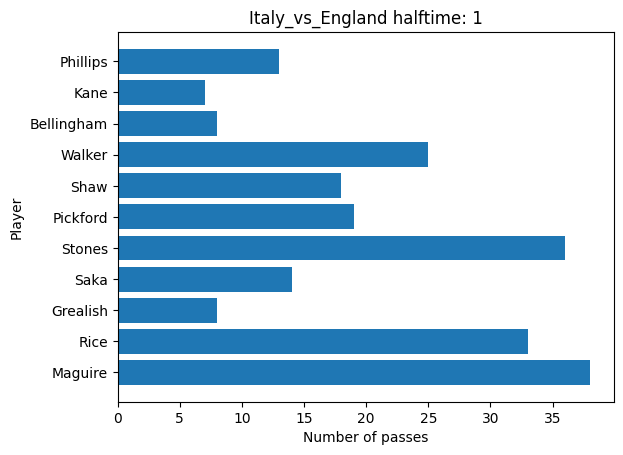

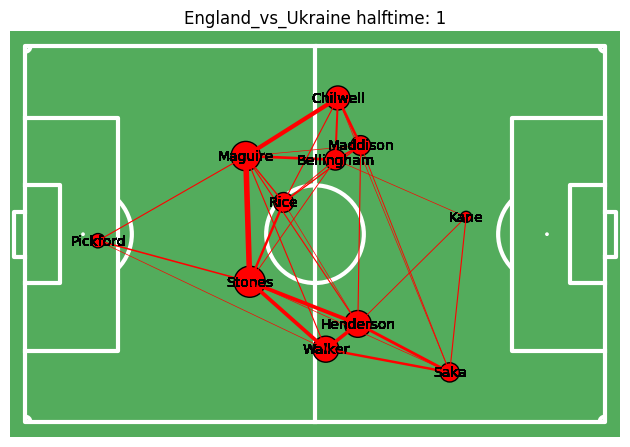

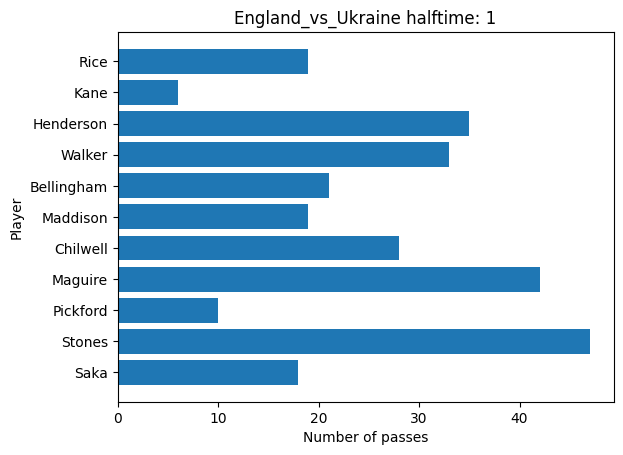

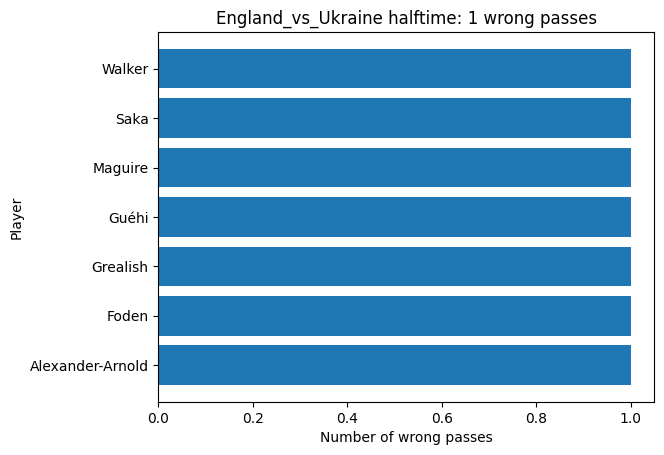

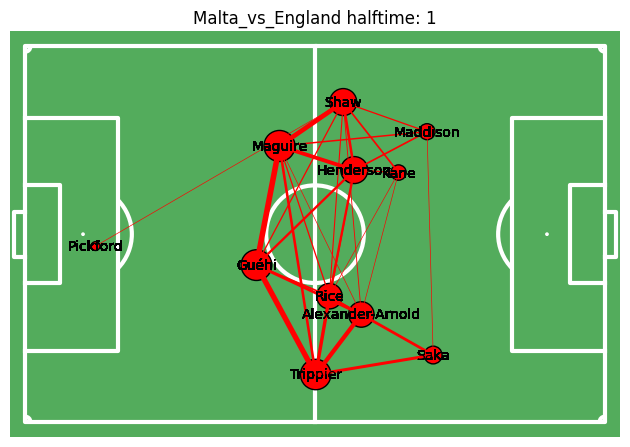

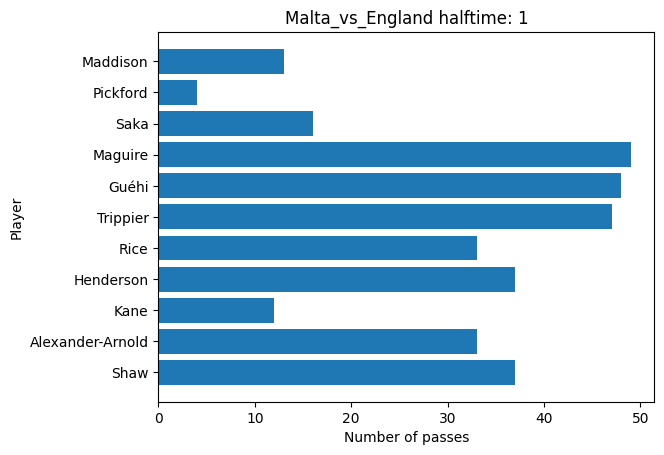

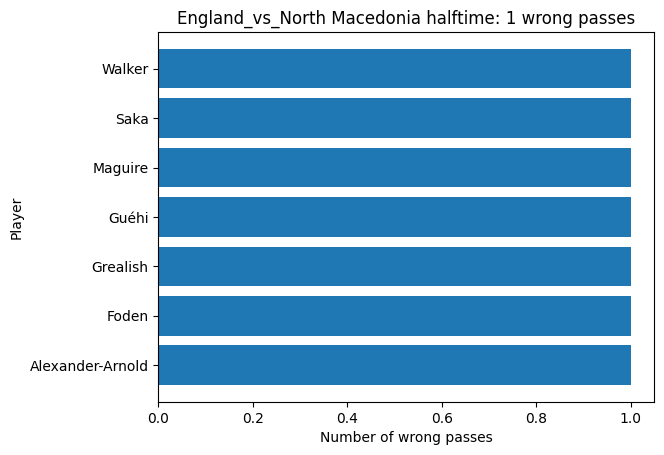

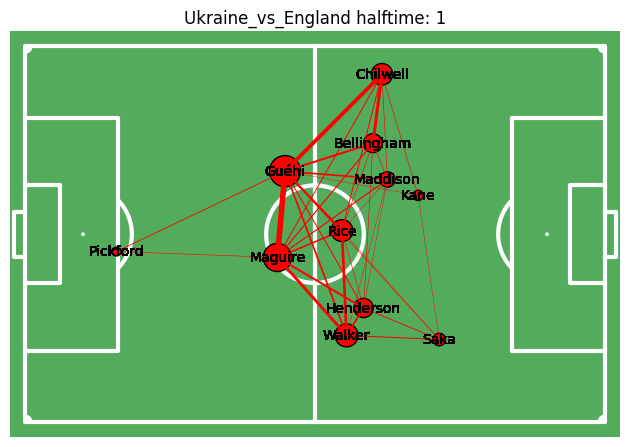

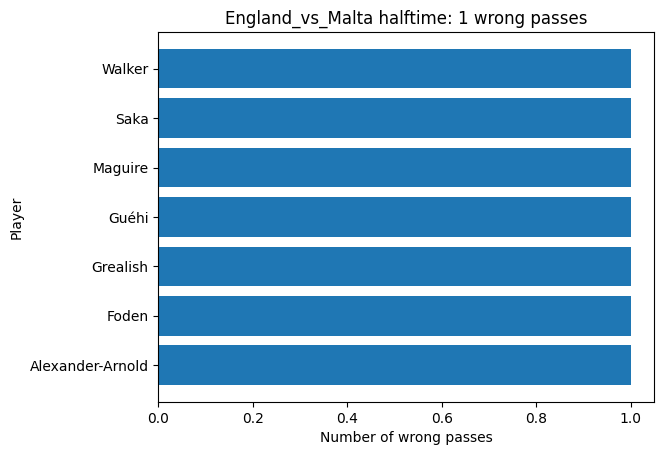

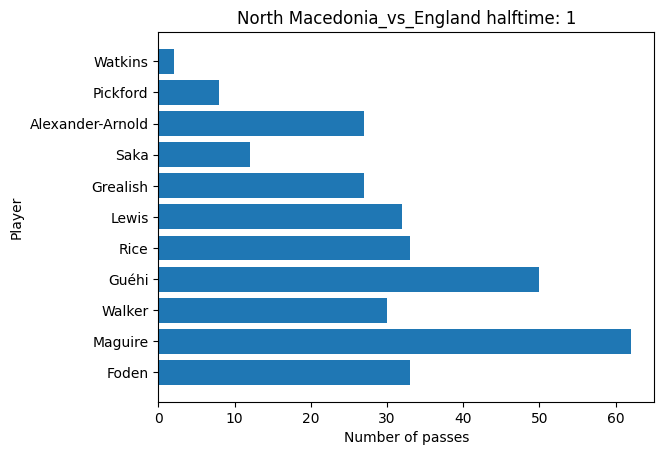

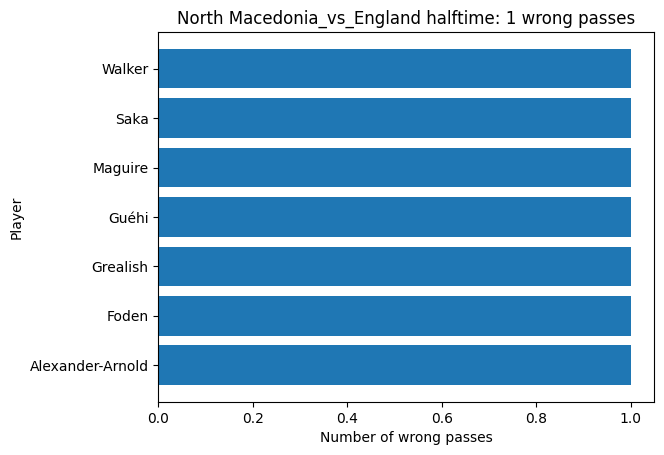

C:\Users\thoma\AppData\Local\Temp\ipykernel_9396\246901810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["matchPeriod"] = df["matchPeriod"].apply(lambda x: 1 if x == "1H" else 2)
C:\Users\thoma\AppData\Local\Temp\ipykernel_9396\246901810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["matchPeriod"] = df["matchPeriod"].apply(lambda x: 1 if x == "1H" else 2)
C:\Users\thoma\AppData\Local\Temp\ipykernel_9396\246901810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

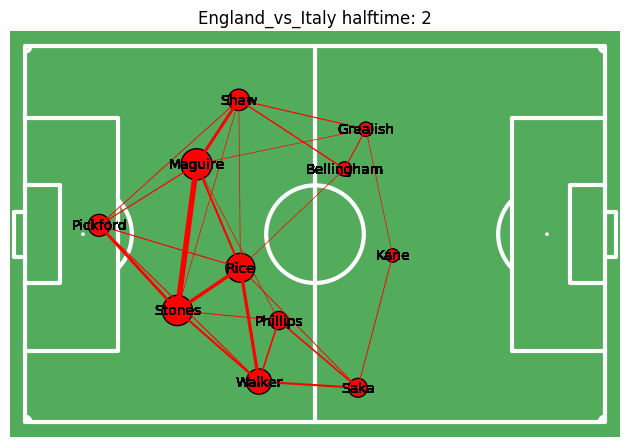

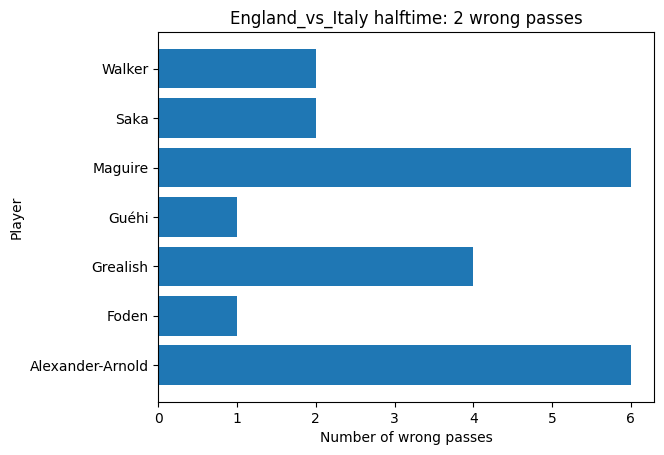

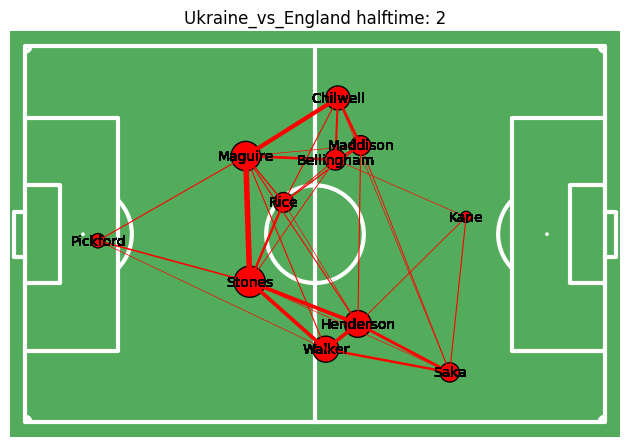

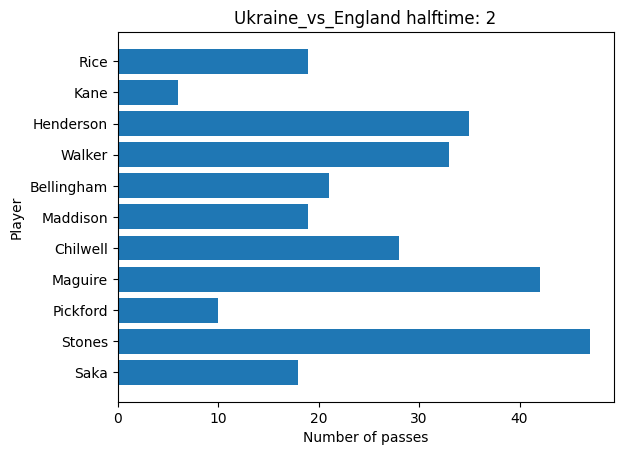

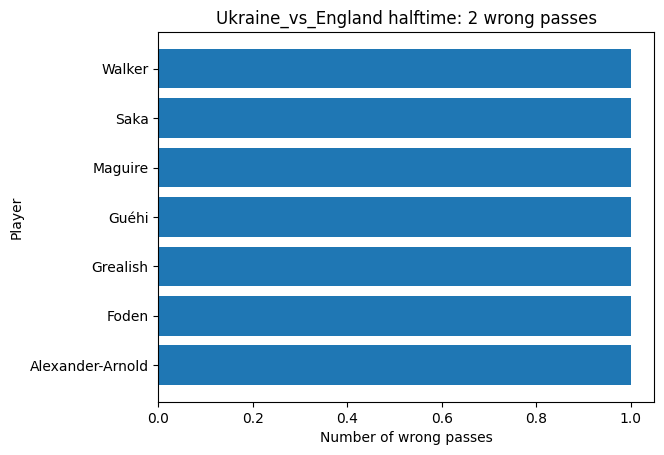

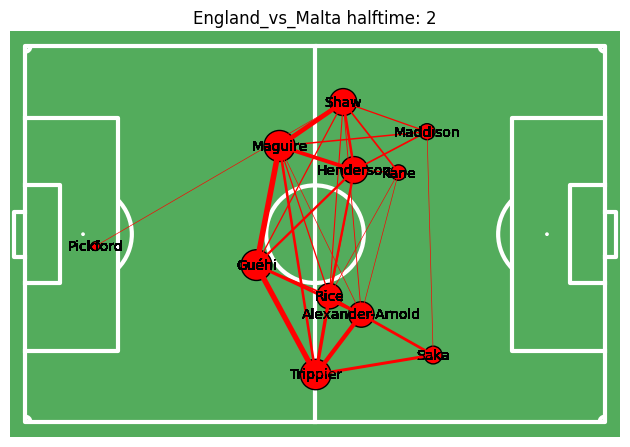

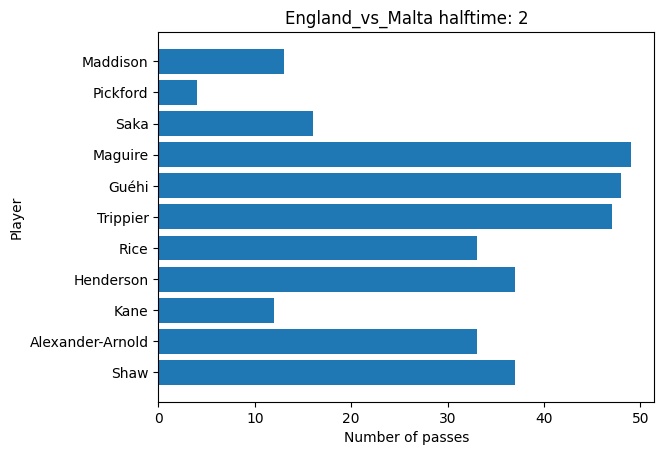

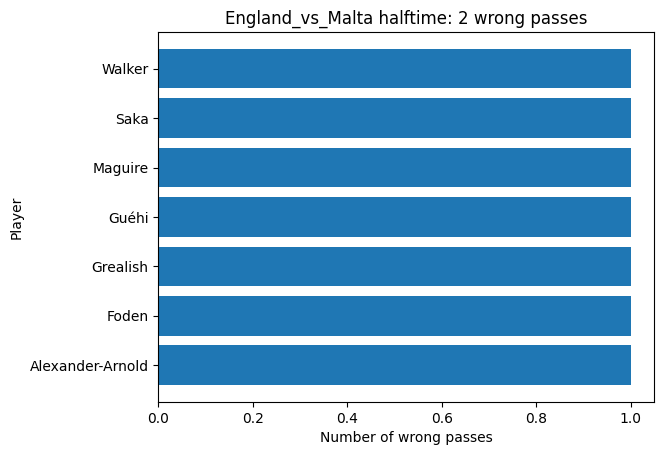

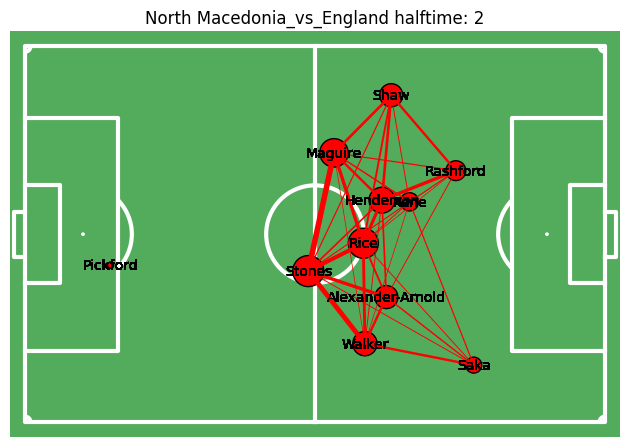

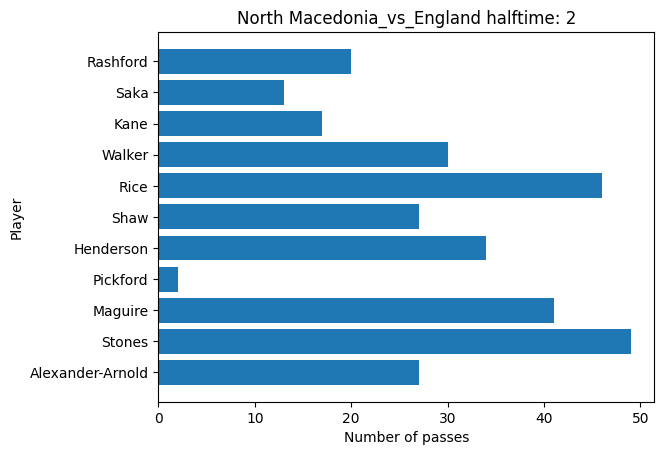

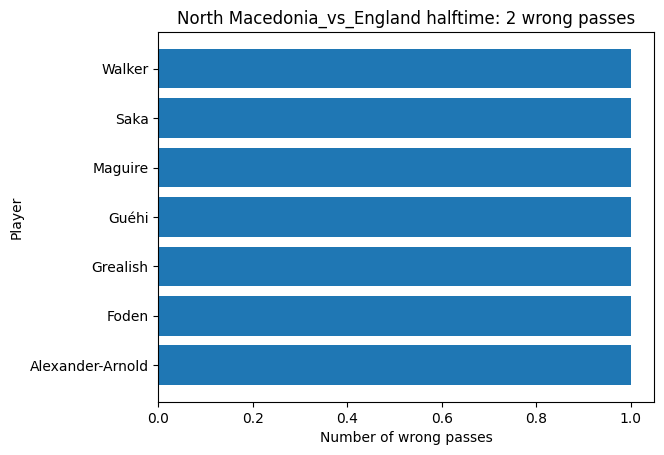

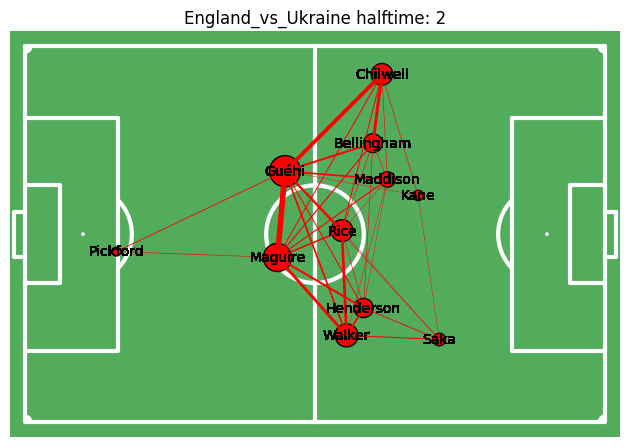

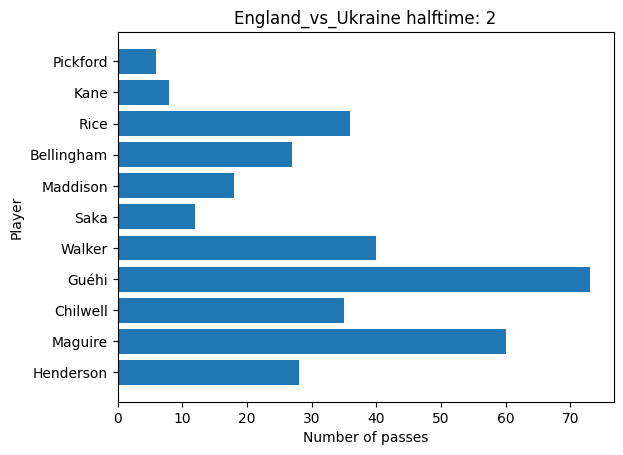

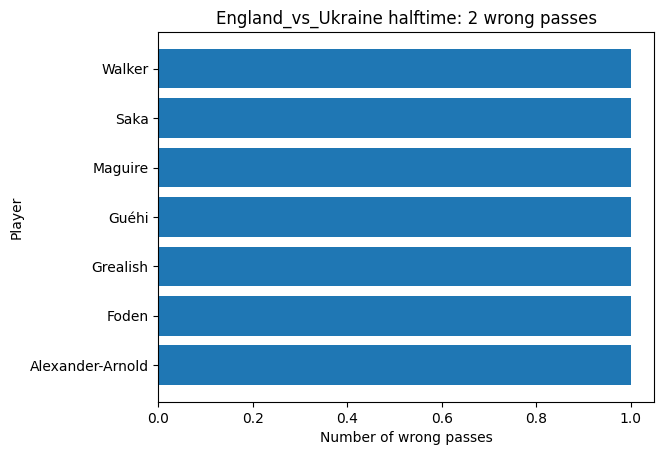

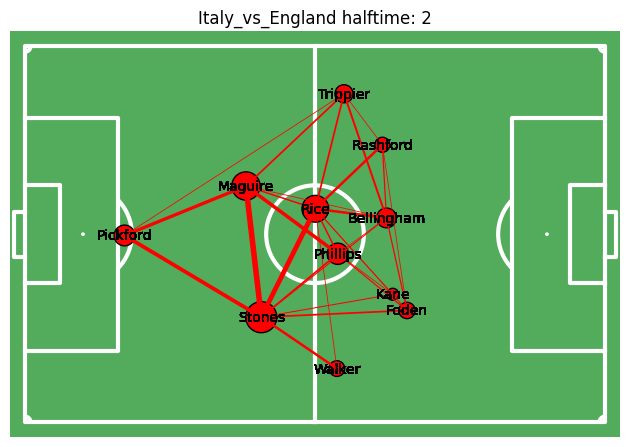

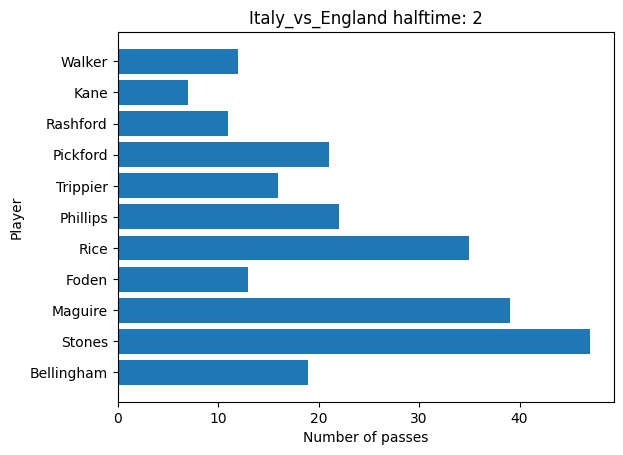

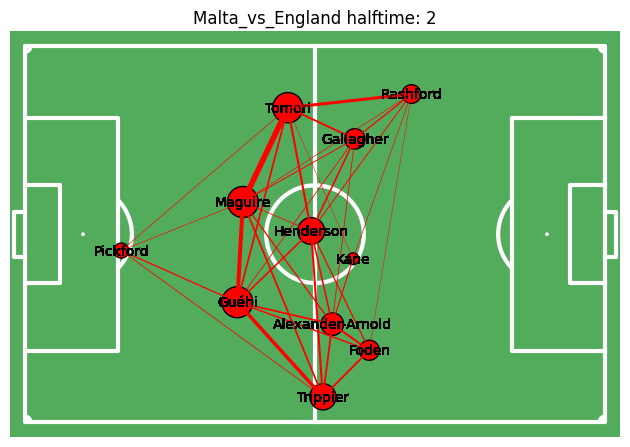

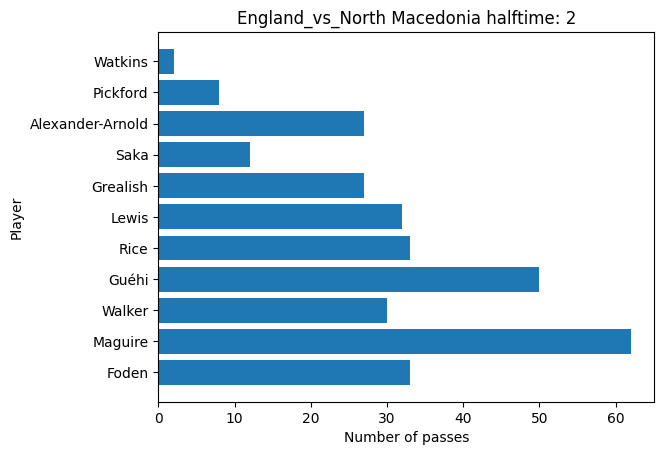

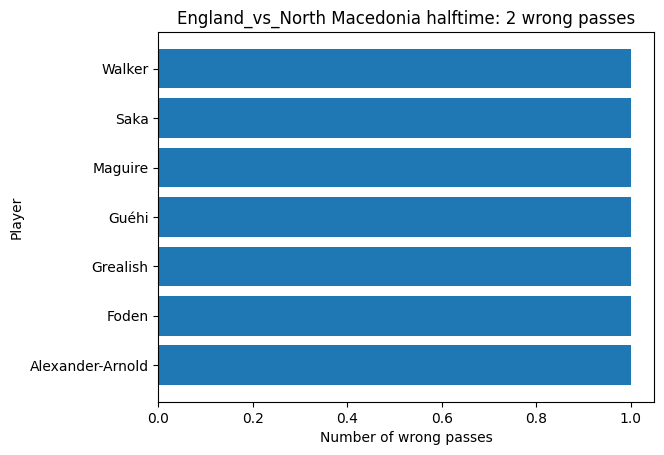

C:\Users\thoma\AppData\Local\Temp\ipykernel_9396\246901810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["matchPeriod"] = df["matchPeriod"].apply(lambda x: 1 if x == "1H" else 2)
C:\Users\thoma\AppData\Local\Temp\ipykernel_9396\246901810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["matchPeriod"] = df["matchPeriod"].apply(lambda x: 1 if x == "1H" else 2)
C:\Users\thoma\AppData\Local\Temp\ipykernel_9396\246901810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

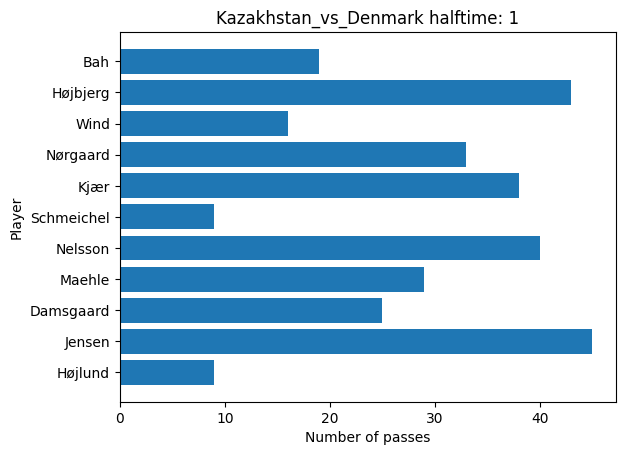

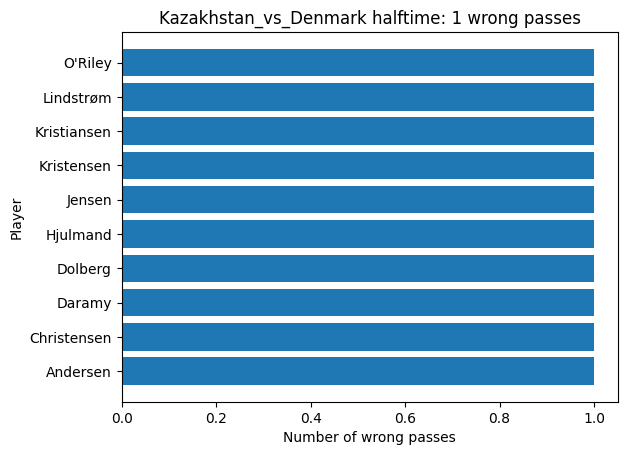

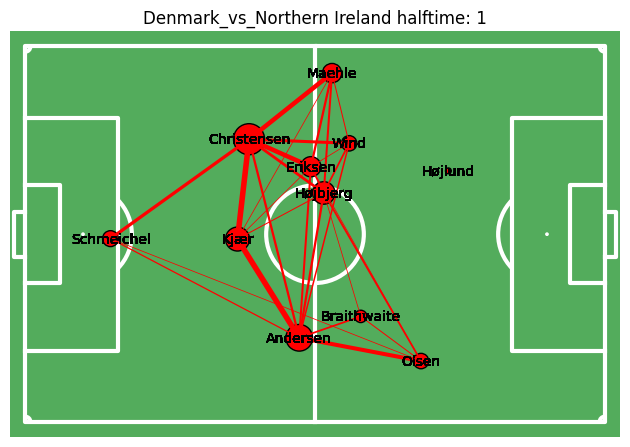

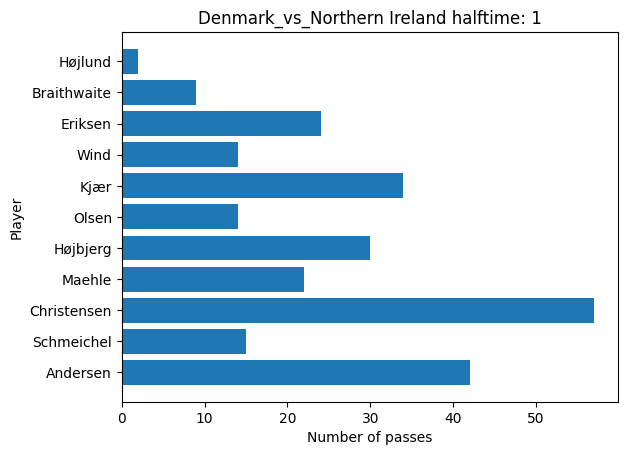

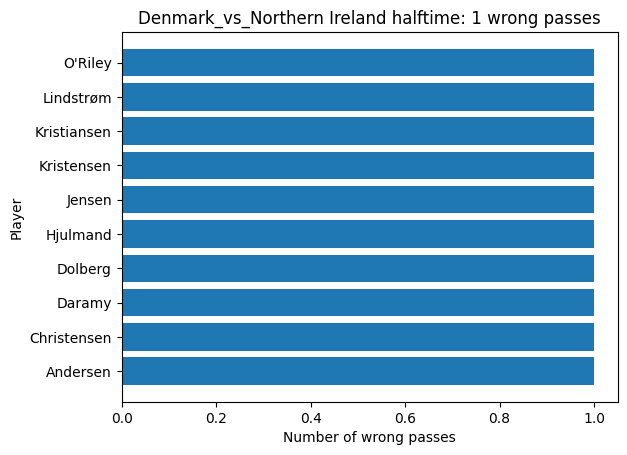

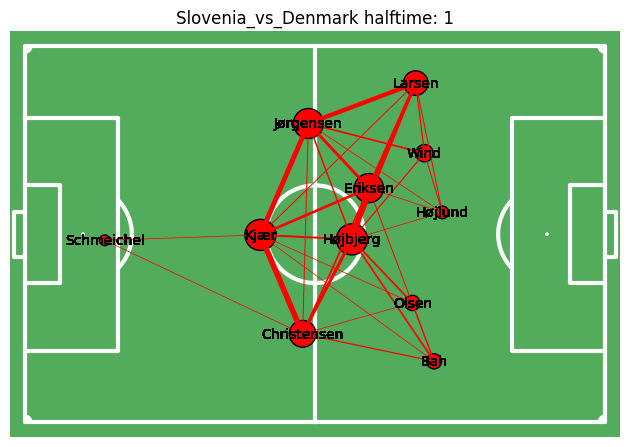

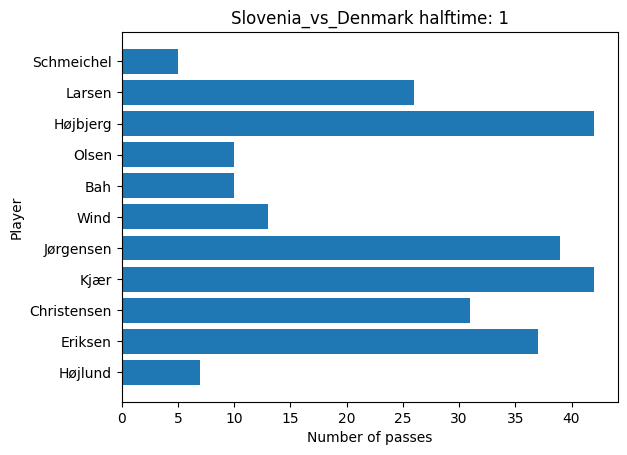

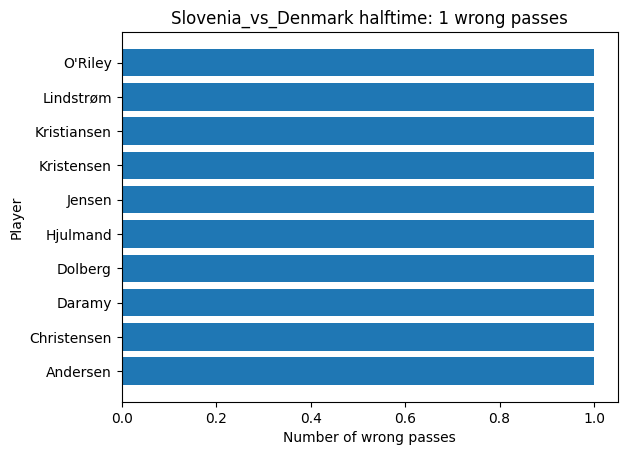

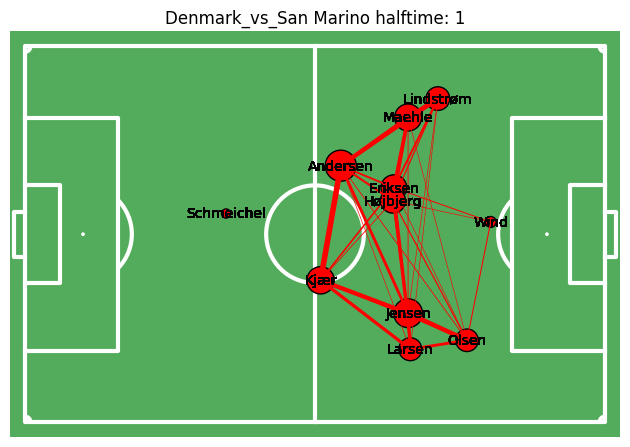

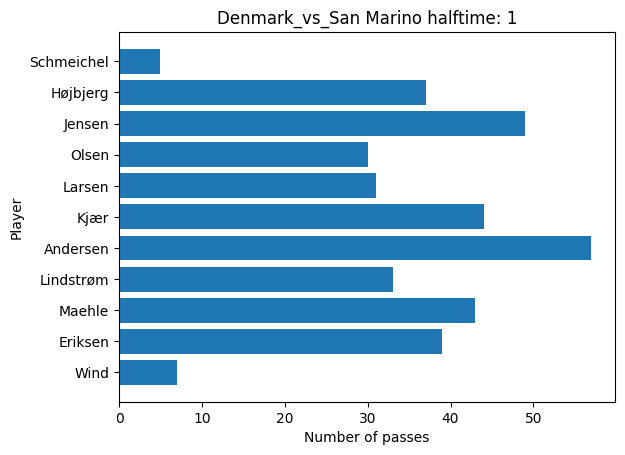

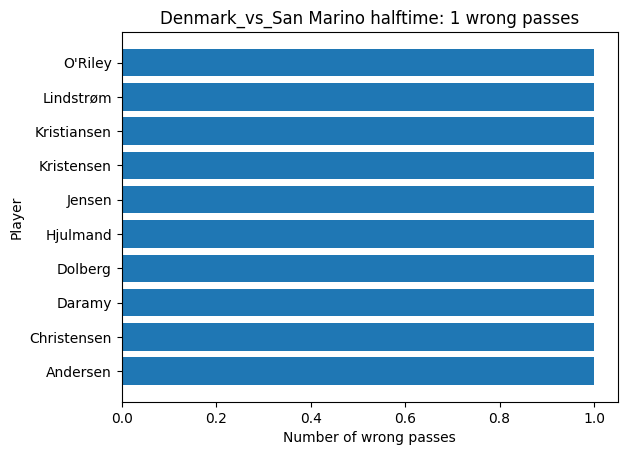

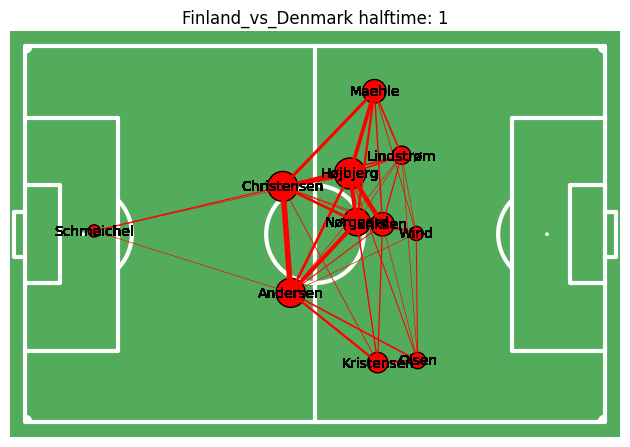

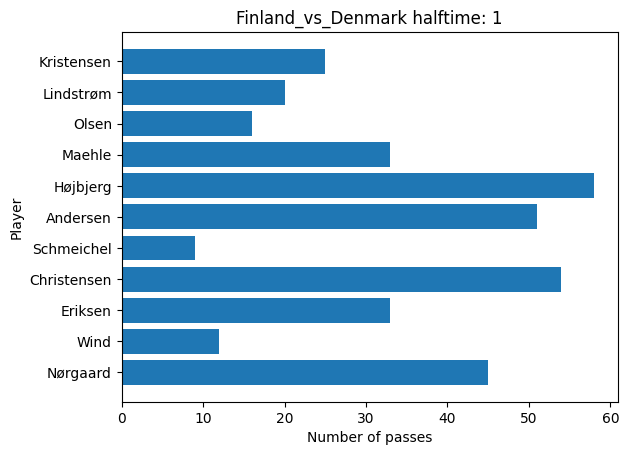

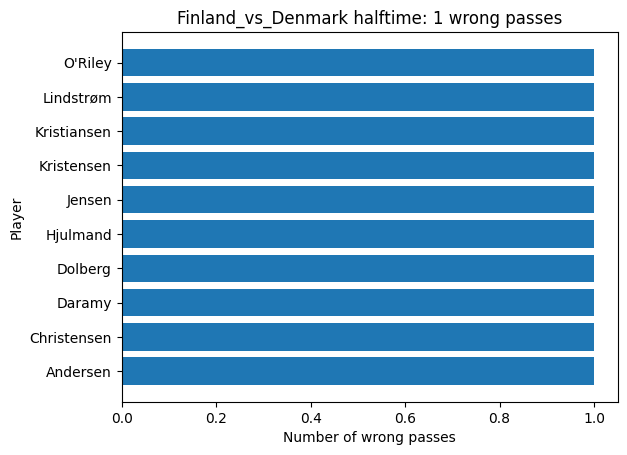

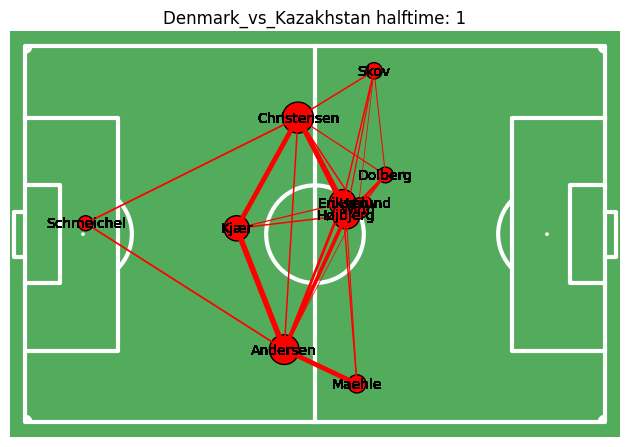

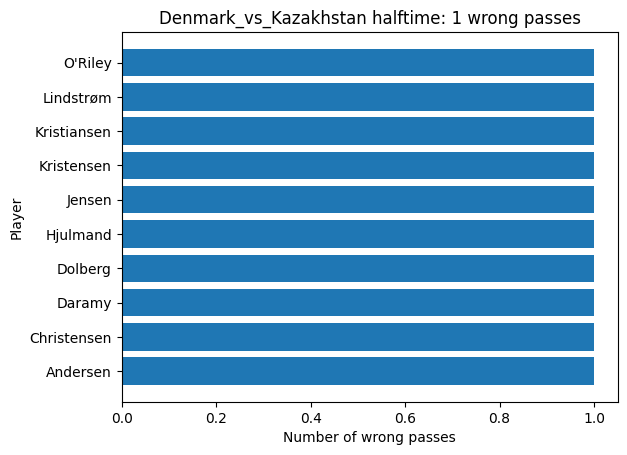

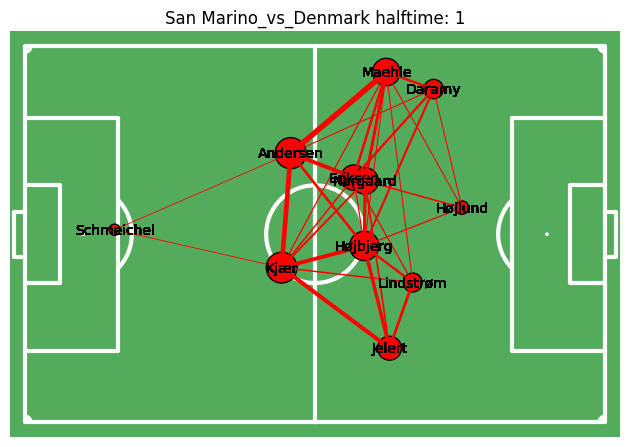

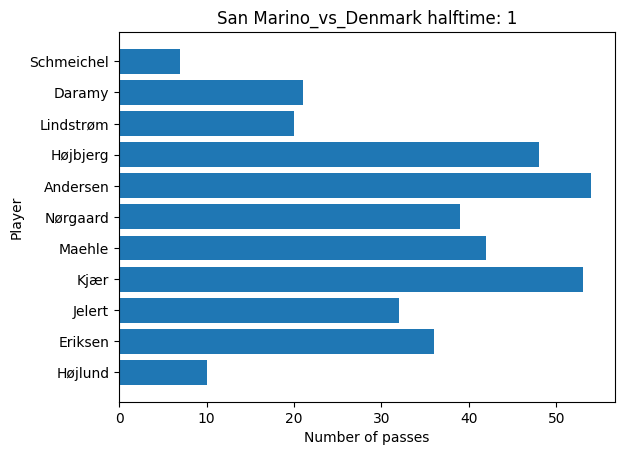

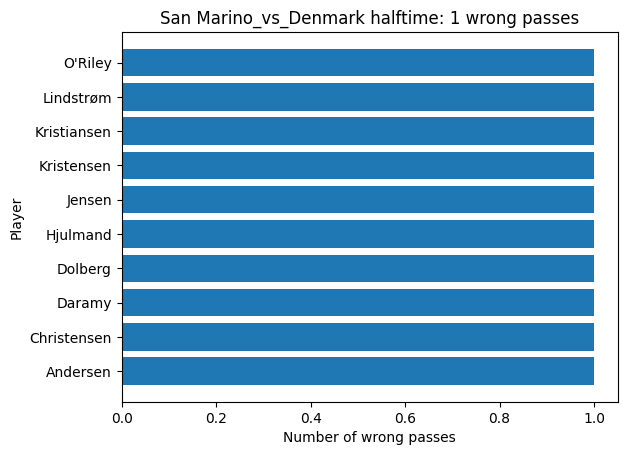

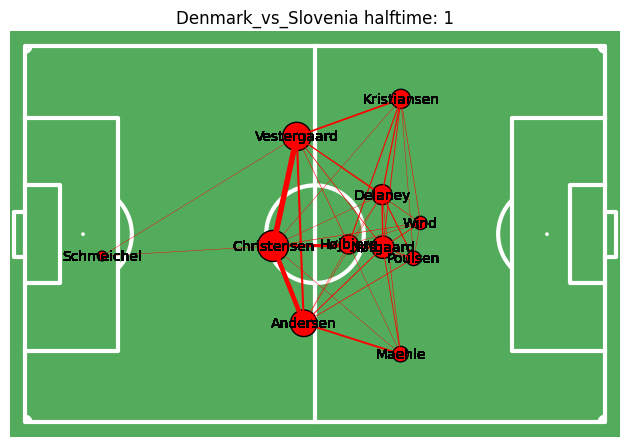

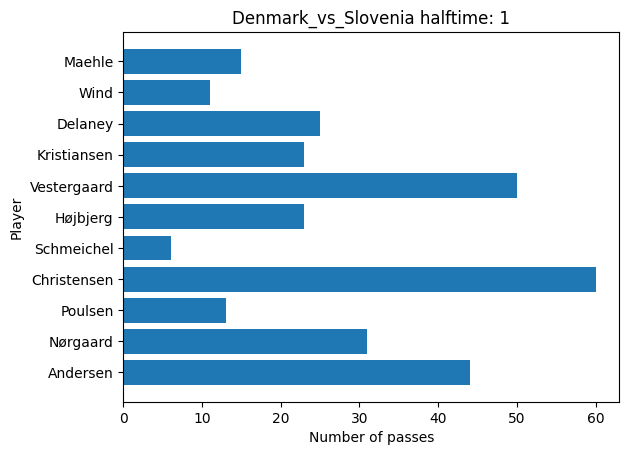

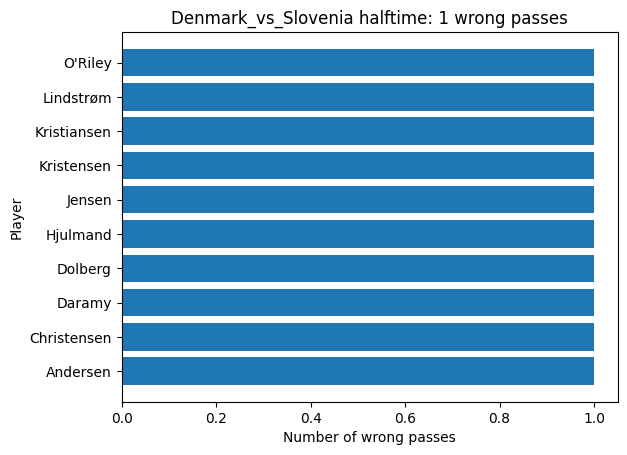

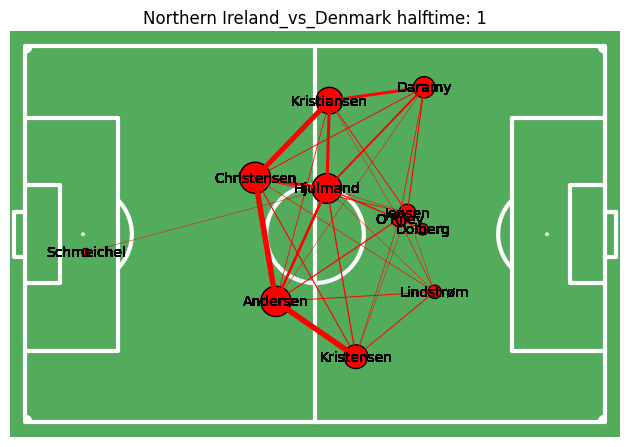

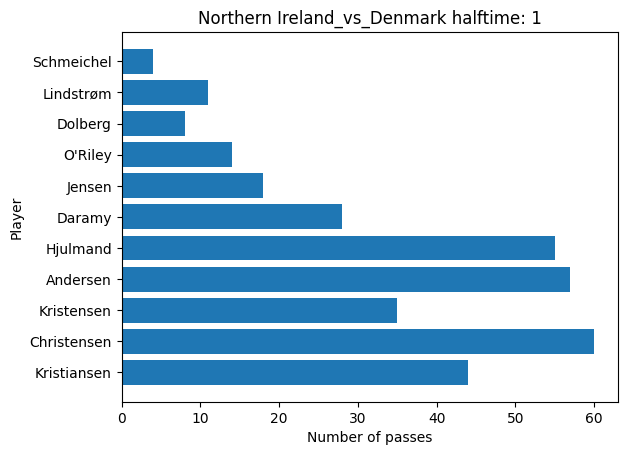

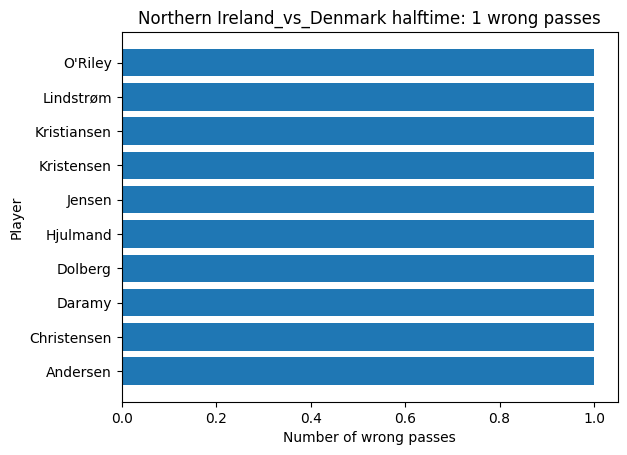

C:\Users\thoma\AppData\Local\Temp\ipykernel_9396\246901810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["matchPeriod"] = df["matchPeriod"].apply(lambda x: 1 if x == "1H" else 2)
C:\Users\thoma\AppData\Local\Temp\ipykernel_9396\246901810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["matchPeriod"] = df["matchPeriod"].apply(lambda x: 1 if x == "1H" else 2)
C:\Users\thoma\AppData\Local\Temp\ipykernel_9396\246901810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

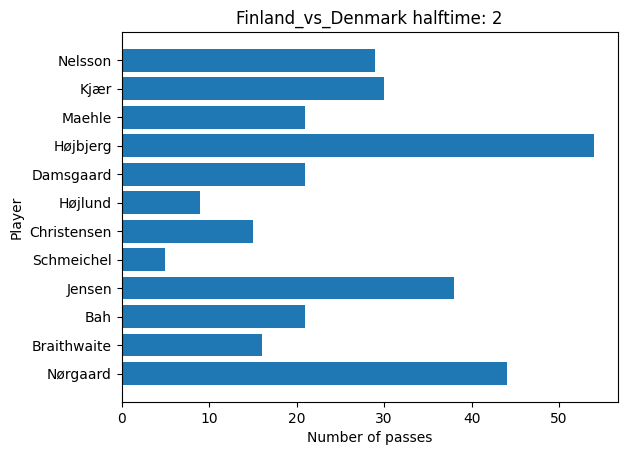

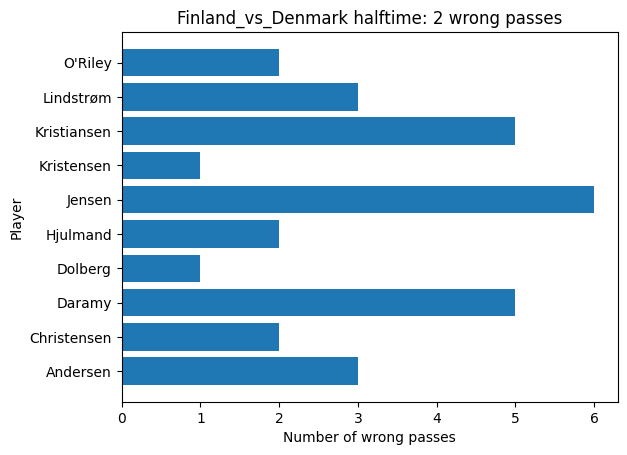

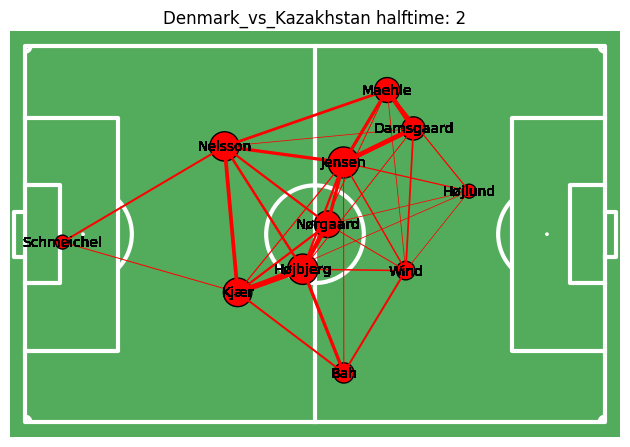

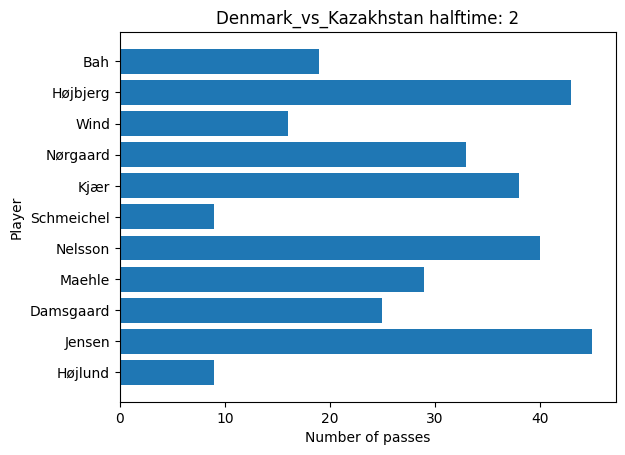

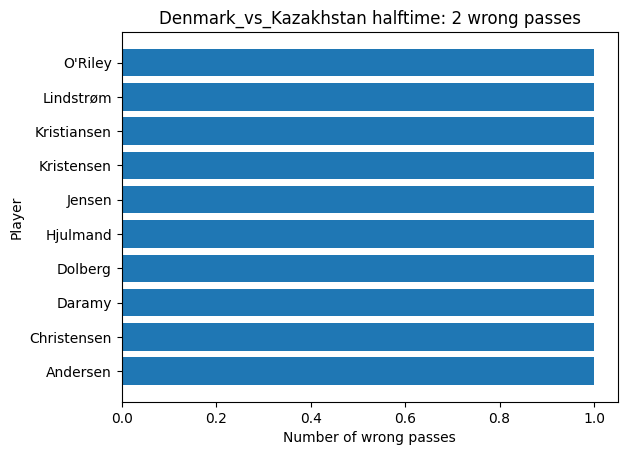

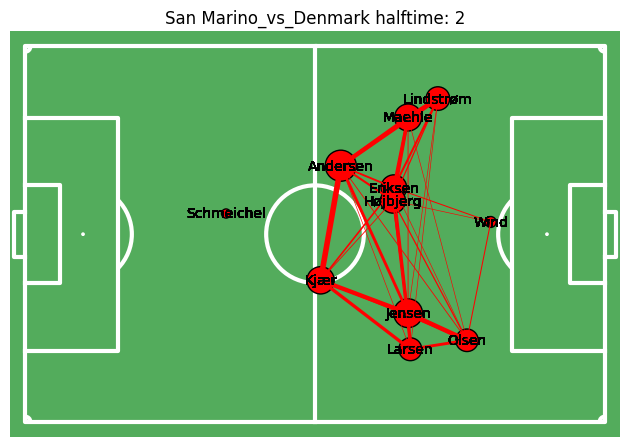

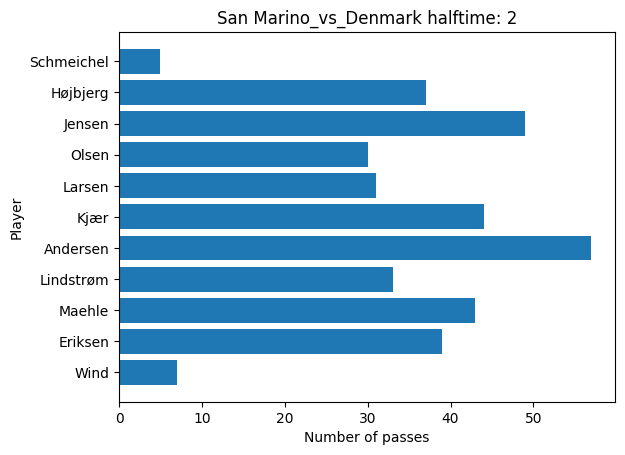

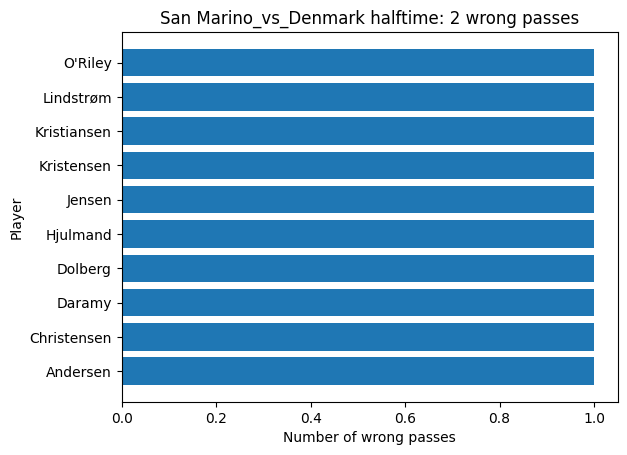

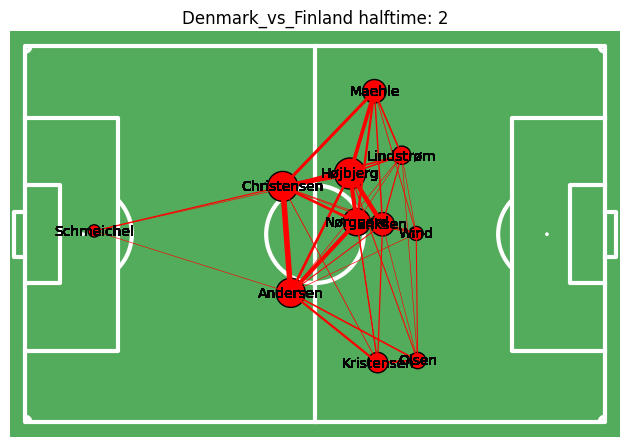

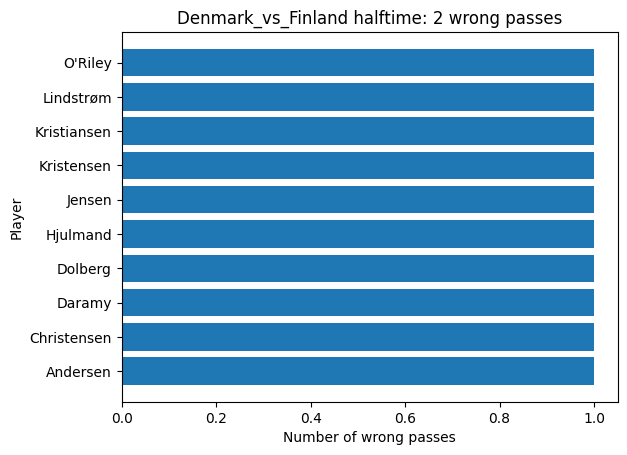

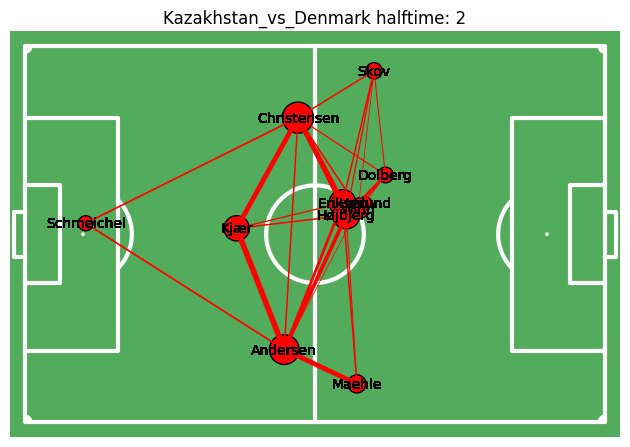

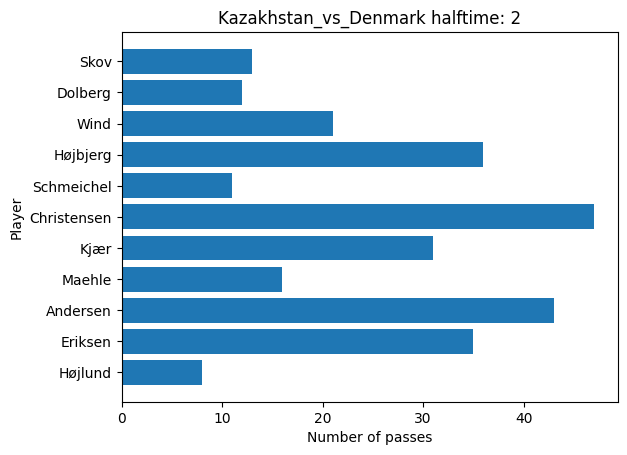

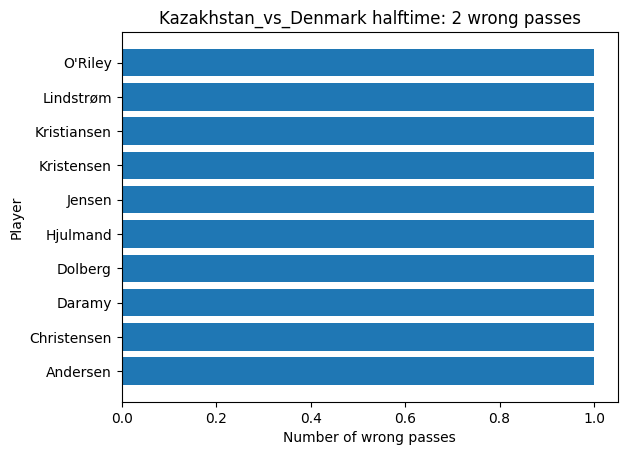

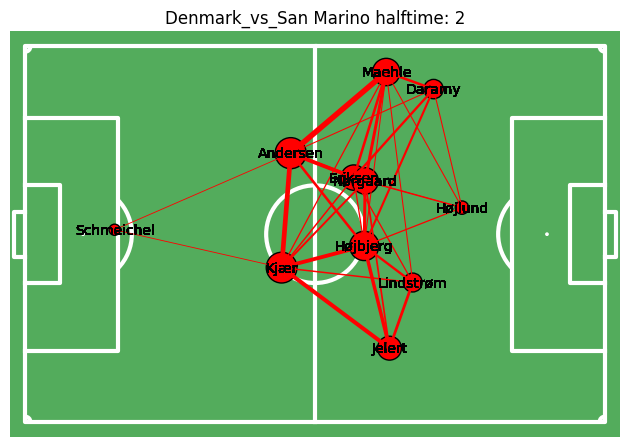

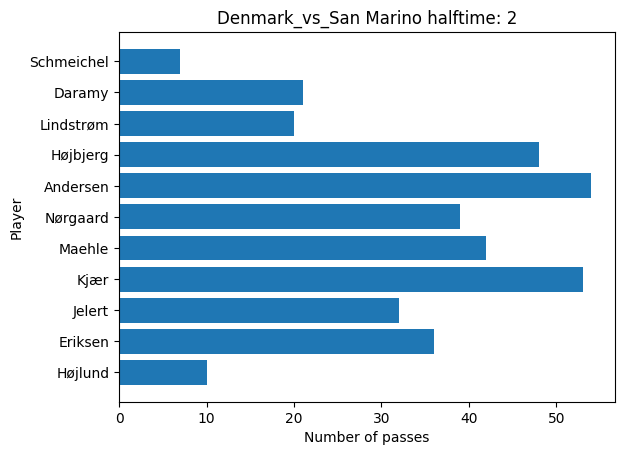

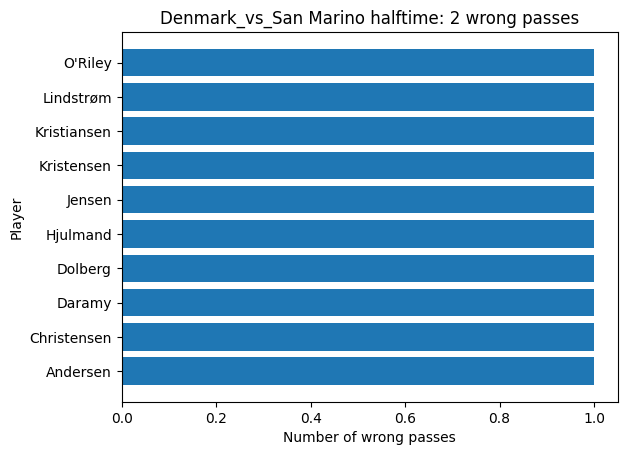

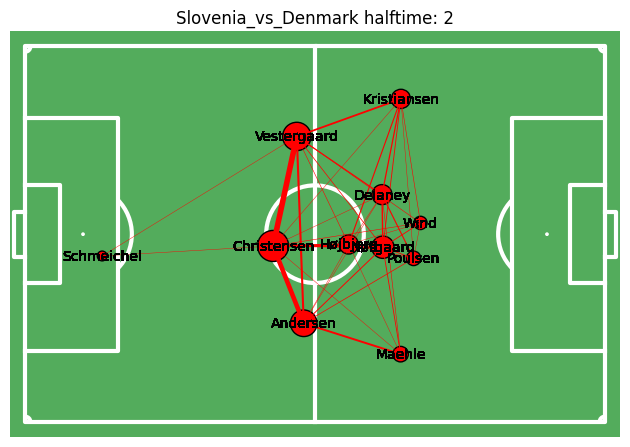

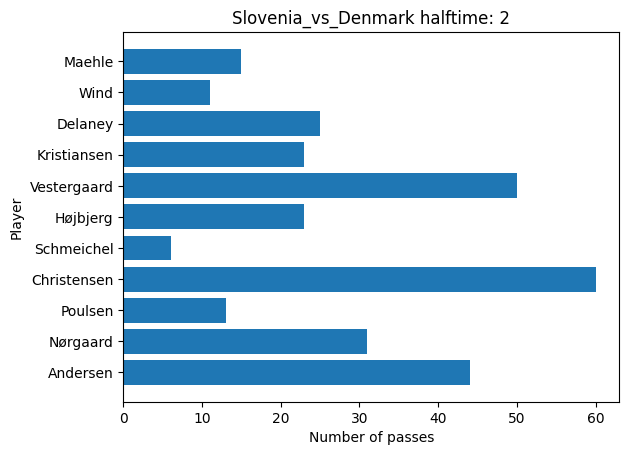

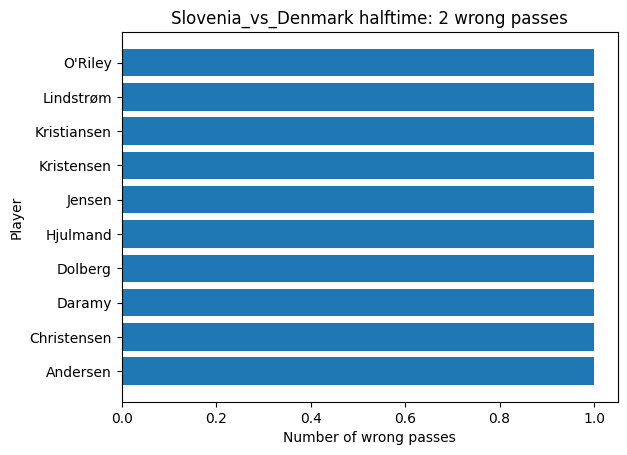

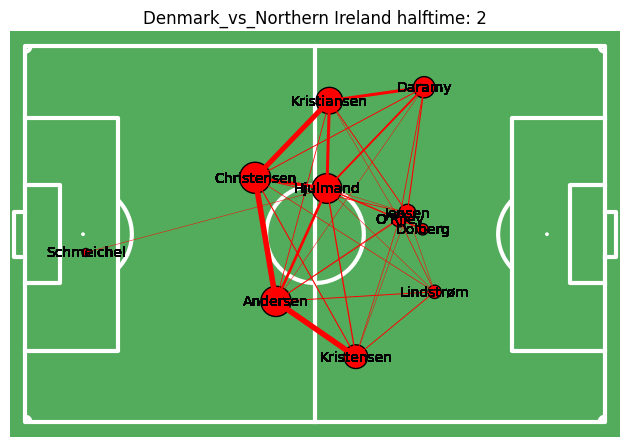

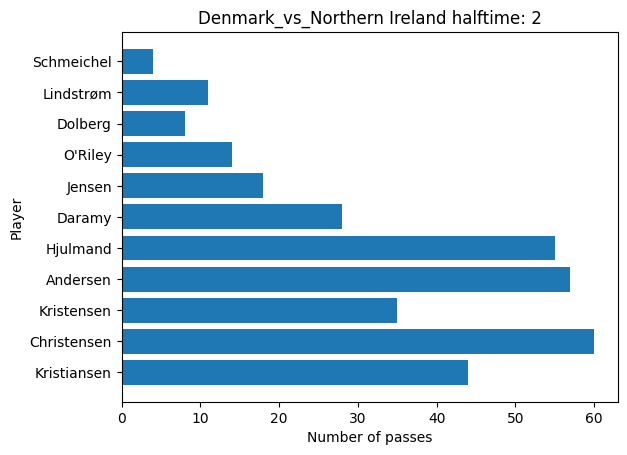

In [88]:

current_directory = Path.cwd()
current_directory = current_directory.parents[0]

teams = ['England', 'Denmark'] #teams to investigate

for team in teams:
    data_dir = os.path.join(current_directory,'data',f'{team}_games')
    data_dir = Path(data_dir)
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    data_dir = Path(data_dir)

    data_path= os.path.join(current_directory,'data')
    wyscout_path = os.path.join(data_path,'wyscout')
    input_dir = os.path.join(data_path,'skillcorner')
    match_id_path = os.path.join(data_path,'matchids.csv')

    match_id = pd.read_csv(match_id_path)
    team_match = match_id[(match_id['home'] == team) | (match_id['away'] == team)]
    team_match_ids_wyscout = team_match['wyscout'].values


    for halftime in range(1,3):
        passes_visualization_halftime(team_match, wyscout_path, halftime, current_directory=current_directory, team = team)







